# Pump-Net: Industrial Pump Anomaly Detection using Deep Learning

## Introduction
Embarking on an ambitious journey to enhance industrial machinery monitoring, this project represents a evolution from my previous work on audio-based anomaly detection. Leveraging the power of machine learning, the aim is to fortify the predictive maintenance capabilities of sensor-based systems, contributing significantly to the field of real-time machinery health assessment.

## About the Project
### Project Overview
Building upon a solid foundation established by the successful "Pump-Net" model, this initiative marks a strategic transition towards unsupervised learning techniques. The previous model, developed with TensorFlow and Scikit-Learn, utilized a subset of the MIMII Dataset and applied advanced data preprocessing alongside audio signal processing. It achieved exemplary performance metrics, highlighting the practical utility and impact of such models in predictive maintenance and operational efficiency.

### Dataset Description
The pump sound dataset is a segment of the MIMII Dataset, featuring acoustic recordings that capture the operational nuances of industrial pumps. It includes a rich tapestry of soundscapes illustrating normal functionality, as well as a series of anomalies. These recordings are complemented by ambient factory noises, rendering a realistic backdrop for the model's training and evaluation.

## Advancing with Unsupervised Learning
In this new phase, I am harnessing unsupervised learning to tackle the inherent challenges of anomaly detection within industrial environments. The focus is on identifying unknown anomalous sounds under conditions where only normal operational sounds have been provided for training. This shift aims to address real-world scenarios where anomalies are rare and unpredictable, thus requiring a model that can generalize well from "normal" to "abnormal" without explicit abnormal examples during training.

The goal is to refine the model to not just identify clear-cut anomalies but to also understand the nuanced spectrum of sounds that characterize the operational health of industrial machinery.

# 1. Importing necessary packages

In [42]:
!pip install librosa

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
#from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


In [44]:
abnormal_pump_path = "/kaggle/input/mimii-pump-sound-dataset/abnormal"
normal_pump_path="/kaggle/input/mimii-pump-sound-dataset/normal"

# 2. Data Preprocessing

In [45]:
def load_audio_files(path, label):
    audio_files = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.wav'):
            file_path = os.path.join(path, filename)
            audio, sample_rate = librosa.load(file_path, sr=None)
            audio_files.append(audio)
            labels.append(label)
    return audio_files, labels, sample_rate

# Load the datasets
abnormal_audio, abnormal_labels, _ = load_audio_files(abnormal_pump_path, label=1)
normal_audio, normal_labels, sample_rate = load_audio_files(normal_pump_path, label=0)


# 3. Feature Extraction
## 3.1 MFCCs (Mel-Frequency Cepstral Coefficients)
MFCCs are widely used in audio processing as they effectively represent the power spectrum of sound.

In [46]:
def extract_mfccs(audio, sample_rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed


## 3.2 Spectral Features
These include features like spectral centroid, spectral roll-off, and spectral contrast.

In [47]:
def extract_spectral_features(audio, sample_rate):
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)[0]
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)[0]
    return np.mean(spectral_centroids), np.mean(spectral_rolloff), np.mean(spectral_contrast)


## 3.3 Temporal Features
These include features like zero-crossing rate and autocorrelation.

In [48]:
def extract_temporal_features(audio):
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
    autocorrelation = librosa.autocorrelate(audio)
    return np.mean(zero_crossing_rate), np.mean(autocorrelation)


## 3.4 Data Augmentation 
Data augmentation can be used to artificially expand your dataset. Here are two common techniques:

* Time Shifting: Slightly shifting the audio in time.
* Adding Noise: Introducing random noise into the audio signal.

In [8]:
def augment_audio(audio, sample_rate, noise_factor=0.005, shift_max=0.2):
    # Time Shifting
    shift = np.random.randint(int(sample_rate * shift_max))
    augmented_audio = np.roll(audio, shift)

    # Adding Noise
    noise = np.random.randn(len(augmented_audio))
    augmented_audio = augmented_audio + noise_factor * noise

    return augmented_audio


## 3.5 Applying Feature Extraction
We can now apply these feature extraction methods to the loaded audio data.

In [49]:
def extract_features(audio_data, sample_rate):
    features = []
    for audio in audio_data:
        mfccs = extract_mfccs(audio, sample_rate)
        spectral_features = extract_spectral_features(audio, sample_rate)
        temporal_features = extract_temporal_features(audio)
        all_features = np.concatenate([mfccs, spectral_features, temporal_features])
        features.append(all_features)
    return np.array(features)

# Extract features for both normal and abnormal data
normal_features = extract_features(normal_audio, sample_rate)
abnormal_features = extract_features(abnormal_audio, sample_rate)

In [81]:
# Assuming you have 13 MFCCs
n_mfcc = 13
mfcc_labels = [f'MFCC_{i+1}' for i in range(n_mfcc)]

# You have 3 spectral features
spectral_labels = ['Spectral Centroid', 'Spectral Rolloff', 'Spectral Contrast']

# You have 2 temporal features
temporal_labels = ['Zero Crossing Rate', 'Autocorrelation']

# Combine all feature labels into a single list
feature_names = mfcc_labels + spectral_labels + temporal_labels

feature_names

['MFCC_1',
 'MFCC_2',
 'MFCC_3',
 'MFCC_4',
 'MFCC_5',
 'MFCC_6',
 'MFCC_7',
 'MFCC_8',
 'MFCC_9',
 'MFCC_10',
 'MFCC_11',
 'MFCC_12',
 'MFCC_13',
 'Spectral Centroid',
 'Spectral Rolloff',
 'Spectral Contrast',
 'Zero Crossing Rate',
 'Autocorrelation']

# 4. Exploratory Data Analysis (EDA)
## 4.1 Visual Analysis
Visualizing the features can helps to understand the differences between normal and abnormal audio data.


### 4.1.1 Feature Distributions:
Plot histograms or density plots to see the distribution of individual features

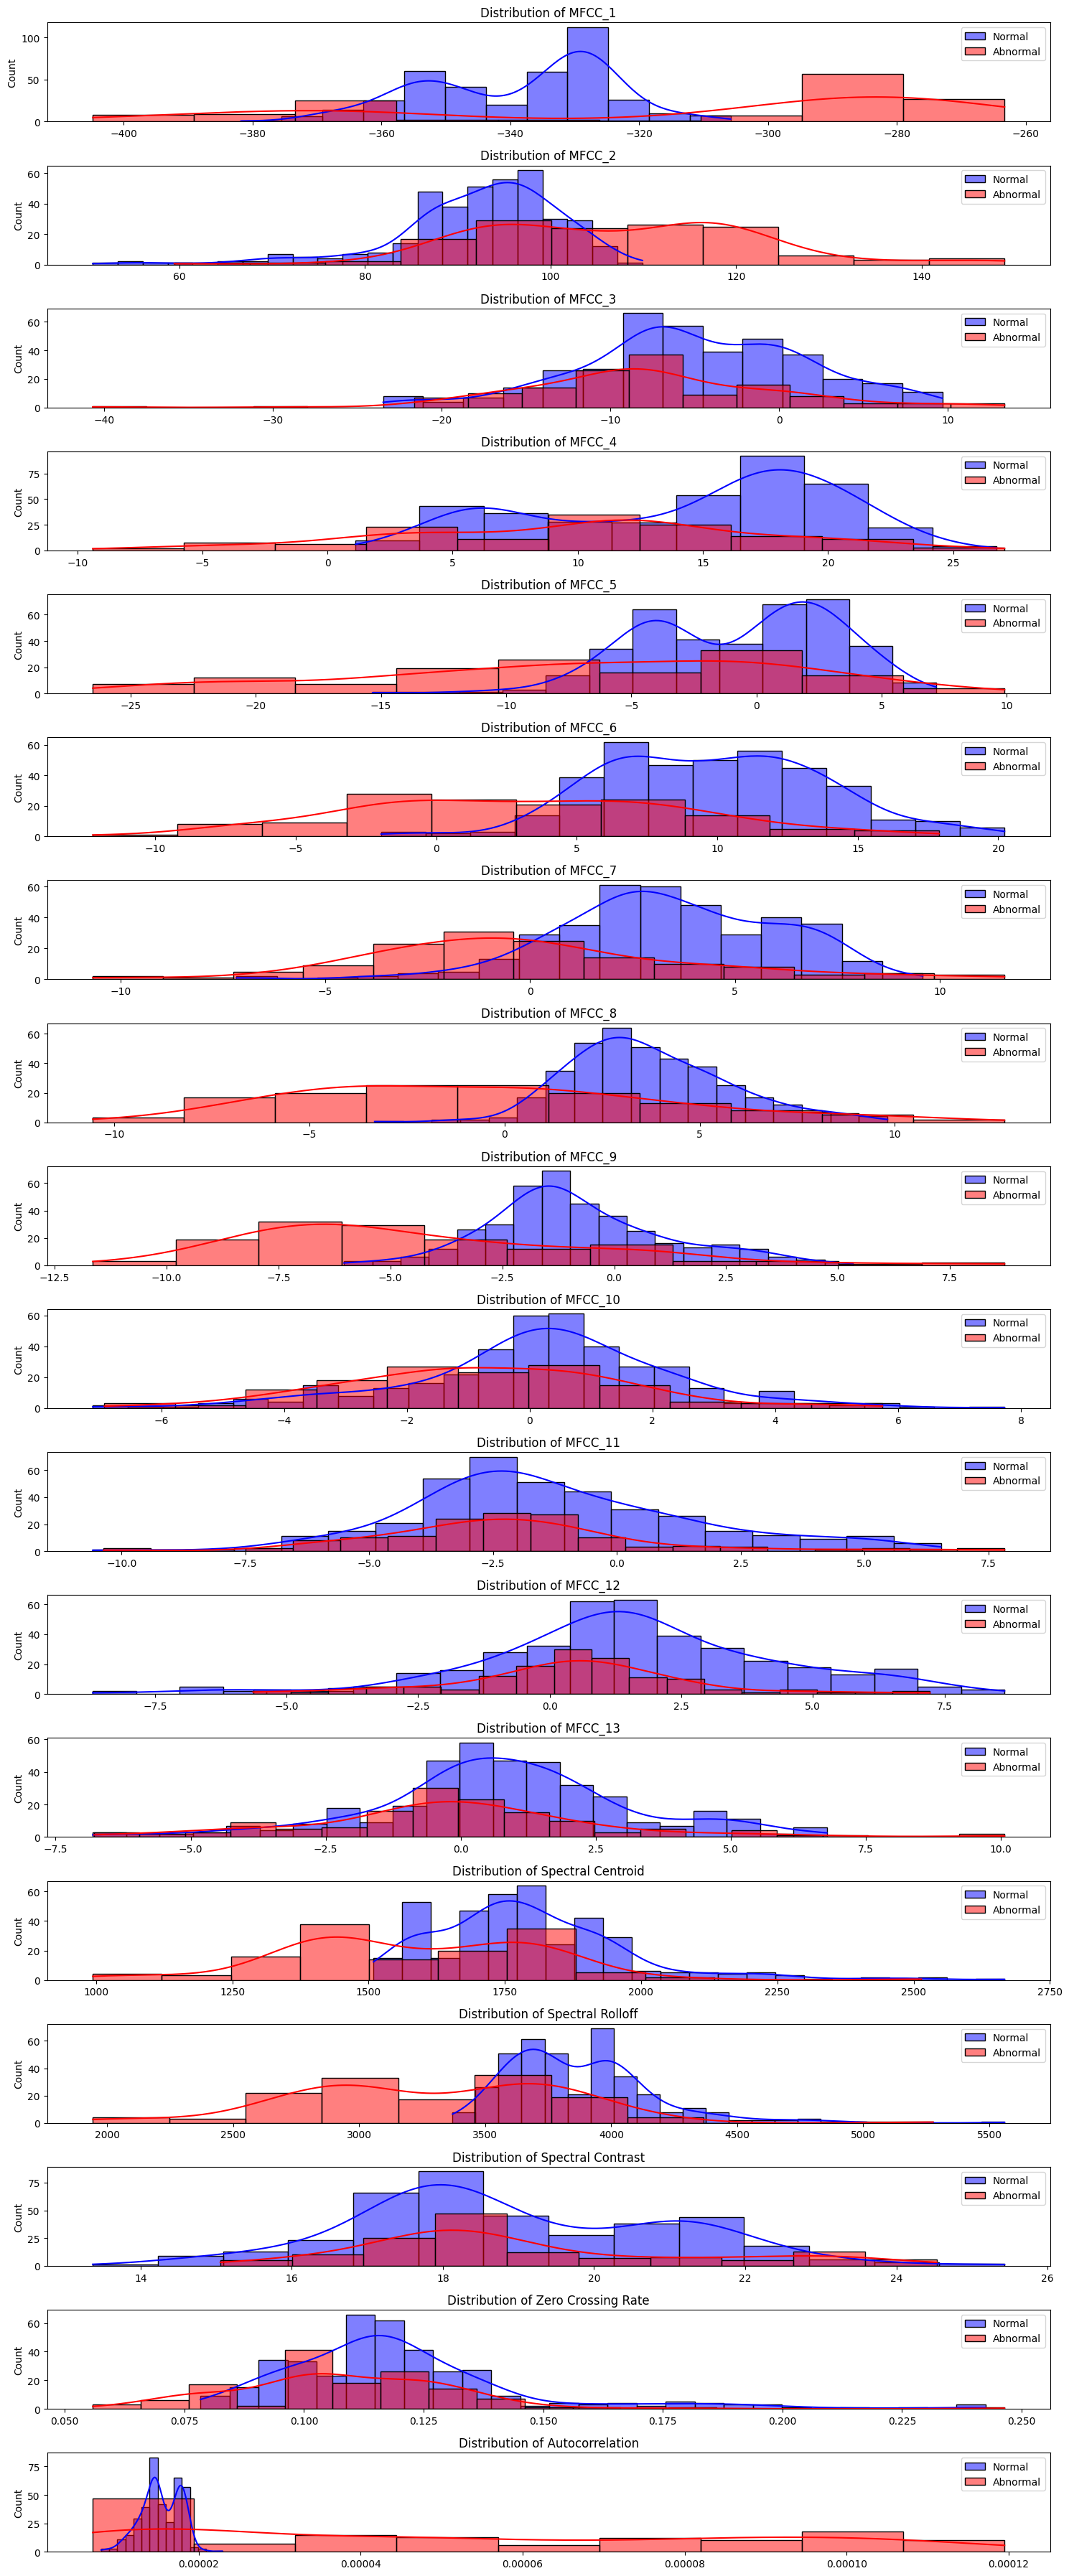

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot feature distributions
def plot_feature_distributions(normal_features, abnormal_features, feature_names):
    number_of_features = normal_features.shape[1]
    plt.figure(figsize=(15, 2 * number_of_features))
    
    for i in range(number_of_features):
        plt.subplot(number_of_features, 1, i + 1)
        sns.histplot(normal_features[:, i], color='blue', label='Normal', kde=True)
        sns.histplot(abnormal_features[:, i], color='red', label='Abnormal', kde=True)
        plt.title(f'Distribution of {feature_names[i]}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting
plot_feature_distributions(normal_features, abnormal_features, feature_names)


### 4.1.2 Feature Correlations:
Use a heatmap to understand the correlation between different features.


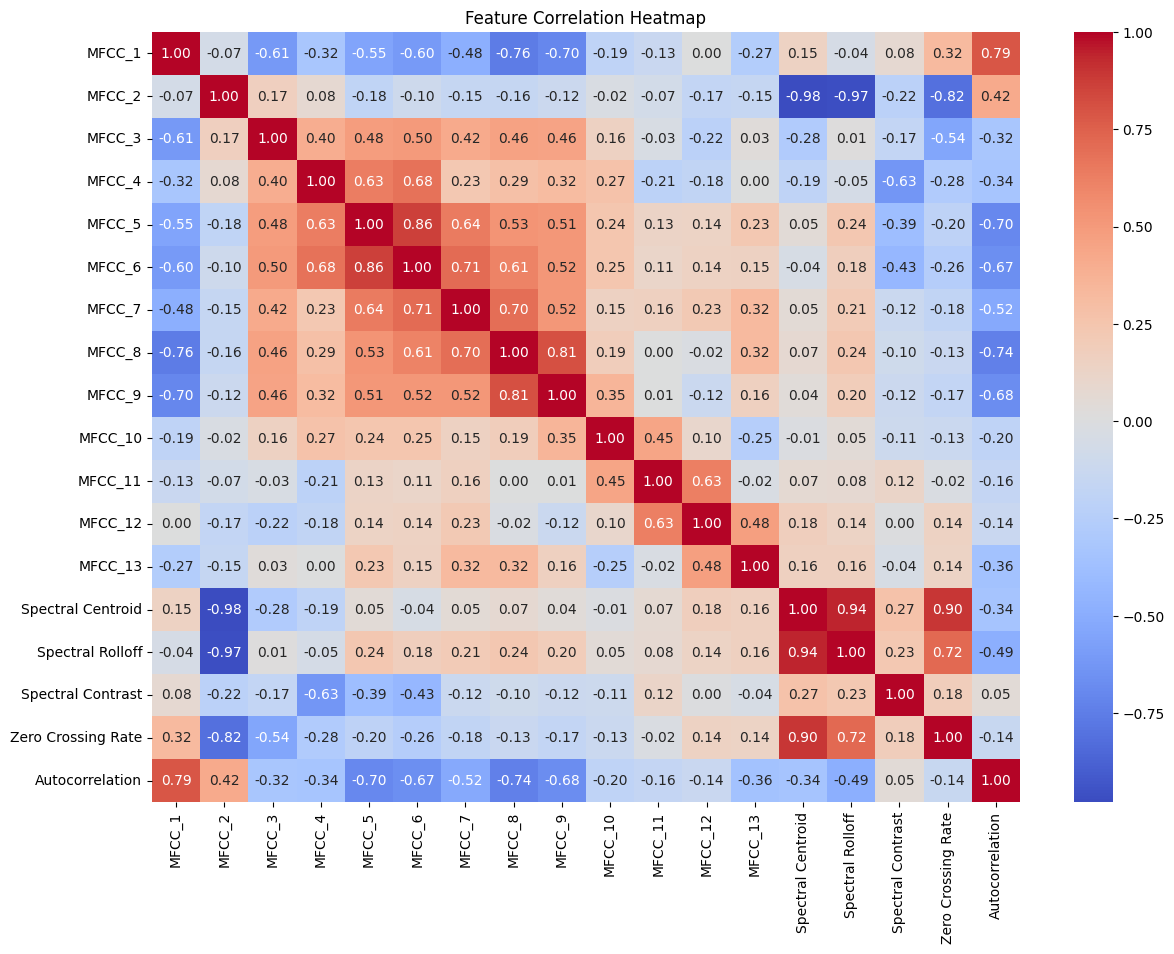

In [53]:
import seaborn as sns

# Assuming 'features' is a combined array of normal and abnormal features
features = np.concatenate((normal_features, abnormal_features))

# Calculate the correlation matrix
corr_matrix = np.corrcoef(features.T)  # Transpose to get features as columns

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=feature_names, yticklabels=feature_names)
plt.title('Feature Correlation Heatmap')
plt.show()


* High Correlation Among MFCCs: Several of the Mel-frequency cepstral coefficients (MFCCs) show a high degree of correlation with each other. This is common as MFCCs are derived from the same cepstral representation of the audio signal. High correlation (close to 1 or -1) suggests redundancy among features, and you might consider dimensionality reduction techniques like PCA to reduce the feature space without losing significant information.

* MFCCs and Temporal Features: There seems to be a moderate to high positive correlation between some of the MFCC features and the autocorrelation feature. This suggests that certain patterns within the MFCCs are reflected in the temporal structure of the audio signal.

* Spectral Features: The spectral centroid, roll-off, and contrast have a lower degree of correlation with the MFCCs. This indicates that spectral features are providing some unique information that is not captured by the MFCCs alone.

* Zero Crossing Rate: The zero-crossing rate (ZCR) shows relatively low correlation with most other features, indicating it's providing unique information that could be valuable in distinguishing between normal and abnormal sounds.

### 4.1.3 Comparing Normal and Abnormal Features:
Using box plots to compare the distributions of features between normal and abnormal samples.

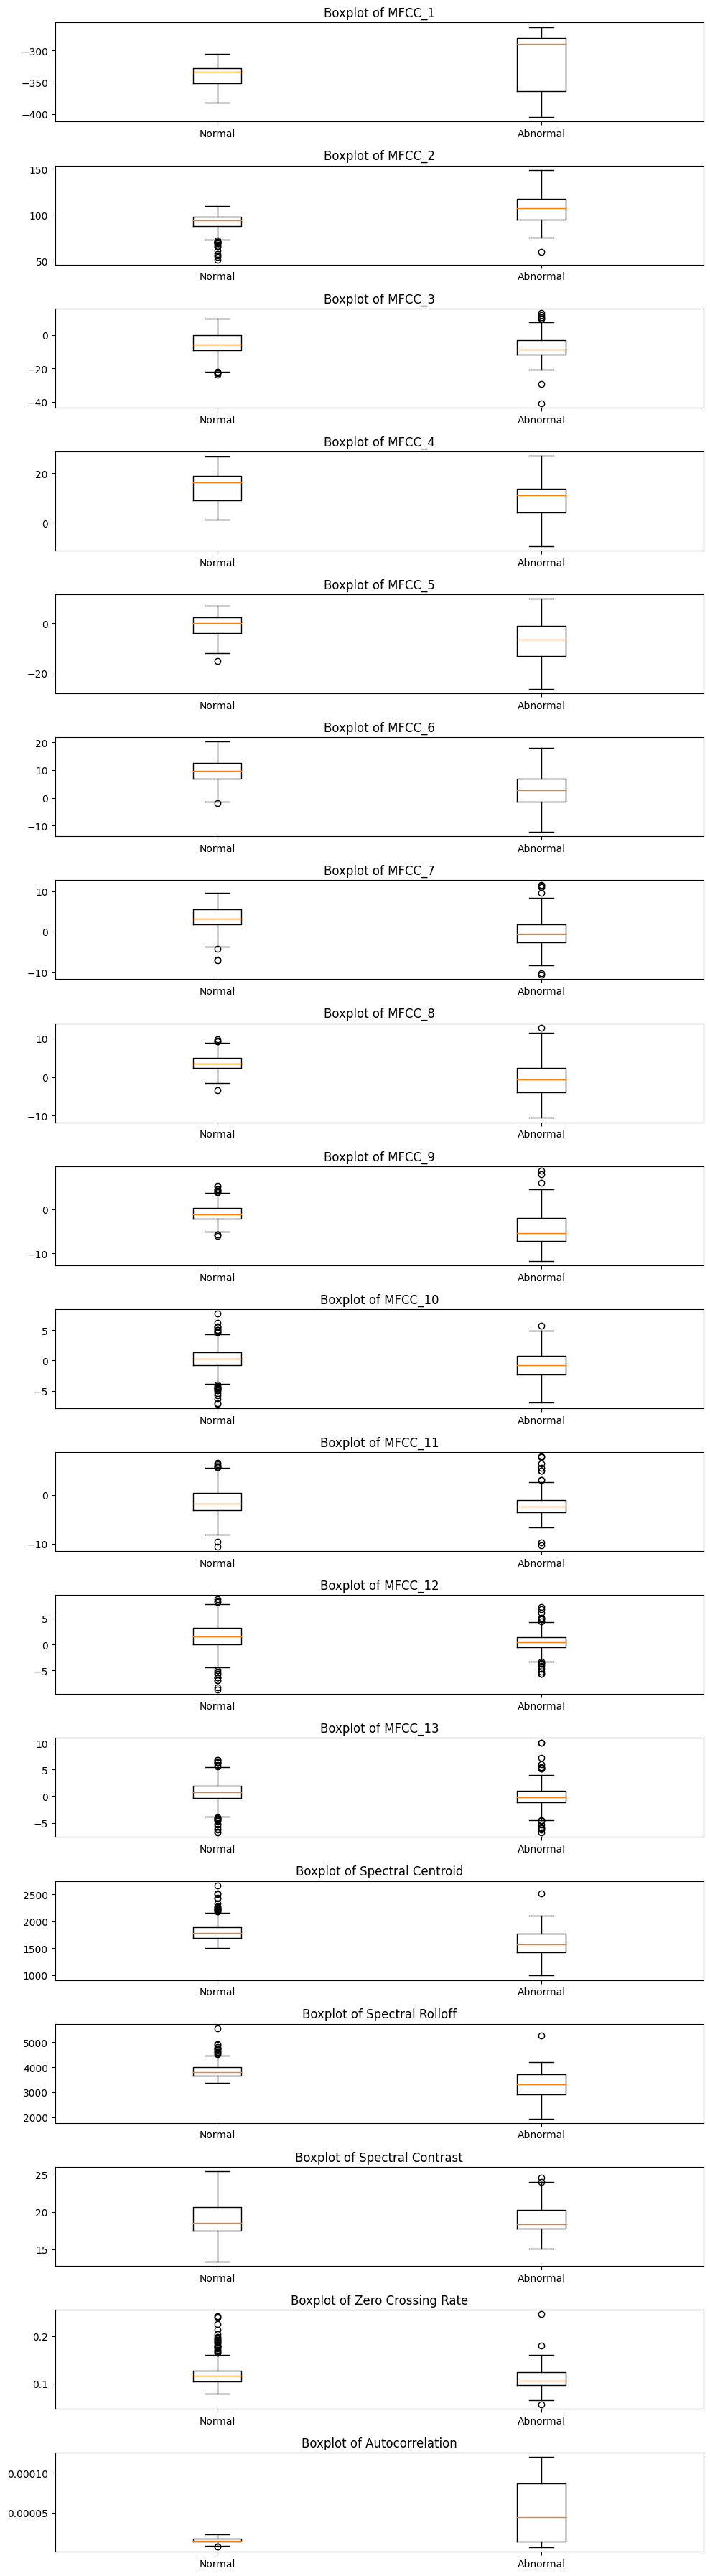

In [56]:
import matplotlib.pyplot as plt

# Boxplot for visualizing the distributions
def plot_feature_boxplots(normal_features, abnormal_features, feature_names):
    number_of_features = normal_features.shape[1]
    fig = plt.figure(figsize=(10, 2 * number_of_features))

    for i in range(number_of_features):
        ax = fig.add_subplot(number_of_features, 1, i + 1)
        ax.boxplot([normal_features[:, i], abnormal_features[:, i]], labels=['Normal', 'Abnormal'])
        ax.set_title(f'Boxplot of {feature_names[i]}')

    plt.tight_layout()
    plt.show()


# Call the function with your data
plot_feature_boxplots(normal_features, abnormal_features, feature_names)


## 4.2 Statistical Analysis
Performing statistical analyses to understand the central tendencies and variations within features.

### 4.2.1 Mean and Standard Deviation:
Calculating these for each feature to get an idea of their central tendency and spread.

In [62]:
# Calculate mean and standard deviation for all features
for i in range(normal_features.shape[1]):
    normal_mean = np.mean(normal_features[:, i])
    normal_std = np.std(normal_features[:, i])
    abnormal_mean = np.mean(abnormal_features[:, i])
    abnormal_std = np.std(abnormal_features[:, i])
    feature = feature_names[i] 
    print(feature)
    print(f"- Normal - Mean: {normal_mean:.2f}, Std Dev: {normal_std:.2f}")
    print(f"- Abnormal - Mean: {abnormal_mean:.2f}, Std Dev: {abnormal_std:.2f}")
    print()  # Print a new line for better readability


MFCC_1
- Normal - Mean: -338.84, Std Dev: 14.39
- Abnormal - Mean: -313.55, Std Dev: 44.00

MFCC_2
- Normal - Mean: 92.36, Std Dev: 8.94
- Abnormal - Mean: 107.33, Std Dev: 15.01

MFCC_3
- Normal - Mean: -5.01, Std Dev: 6.69
- Abnormal - Mean: -7.80, Std Dev: 7.73

MFCC_4
- Normal - Mean: 14.47, Std Dev: 5.86
- Abnormal - Mean: 10.04, Std Dev: 7.34

MFCC_5
- Normal - Mean: -0.72, Std Dev: 3.83
- Abnormal - Mean: -7.09, Std Dev: 8.37

MFCC_6
- Normal - Mean: 9.85, Std Dev: 3.92
- Abnormal - Mean: 3.02, Std Dev: 5.86

MFCC_7
- Normal - Mean: 3.40, Std Dev: 2.66
- Abnormal - Mean: 0.02, Std Dev: 4.00

MFCC_8
- Normal - Mean: 3.68, Std Dev: 2.03
- Abnormal - Mean: -0.50, Std Dev: 4.70

MFCC_9
- Normal - Mean: -0.82, Std Dev: 2.01
- Abnormal - Mean: -4.41, Std Dev: 3.81

MFCC_10
- Normal - Mean: 0.21, Std Dev: 2.13
- Abnormal - Mean: -0.77, Std Dev: 2.28

MFCC_11
- Normal - Mean: -1.31, Std Dev: 2.84
- Abnormal - Mean: -2.18, Std Dev: 2.81

MFCC_12
- Normal - Mean: 1.56, Std Dev: 2.81
- Abn

1. MFCCs:

* MFCC_1: The mean of the normal sounds is significantly lower than that of the abnormal sounds, and the standard deviation for abnormal sounds is much higher, indicating more variability in the abnormal class.
* MFCC_2: Abnormal sounds have a higher mean and more variability.
* MFCCs 3-13: Generally, abnormal sounds tend to have a lower mean across these coefficients, and the standard deviations are often higher compared to normal sounds, suggesting more diverse acoustic properties in the abnormal class.

2. Spectral Features:

* Spectral Centroid: The centroid for normal sounds is higher on average, which might be indicative of a brighter timbre, while the abnormal sounds have a wider spread of values.
* Spectral Rolloff: The rolloff point for normal sounds is higher, suggesting that their energy distribution extends further into the higher frequencies compared to abnormal sounds.
* Spectral Contrast: There is a slight difference in the mean contrast, though standard deviations are similar, implying similar levels of contrast variability between the two classes.

3. Zero Crossing Rate:
* The mean ZCR for normal sounds is slightly higher, with a wider range of values, which could be related to the texture or the percussiveness of the sounds.

4. Autocorrelation:
* Both normal and abnormal sounds have low means and standard deviations for autocorrelation, due to the scaling of the values.

### 4.2.2 Statistical Tests:
Tests like t-tests helps to see if the differences in features between normal and abnormal sounds are statistically significant.

In [63]:
from scipy.stats import ttest_ind

# Perform t-tests for all features
for i in range(normal_features.shape[1]):
    t_stat, p_val = ttest_ind(normal_features[:, i], abnormal_features[:, i])
    
    # Assuming you have a list of feature names
    feature_name = feature_names[i]
    
    # Print the t-statistic and p-value for each feature
    print(f"{feature_name}:")
    print(f"  T-Stat = {t_stat:.3f}, P-value = {p_val:.3g}")
    print()


MFCC_1:
  T-Stat = -9.837, P-value = 4.79e-21

MFCC_2:
  T-Stat = -13.819, P-value = 3.43e-37

MFCC_3:
  T-Stat = 4.021, P-value = 6.65e-05

MFCC_4:
  T-Stat = 7.079, P-value = 4.77e-12

MFCC_5:
  T-Stat = 11.809, P-value = 1.17e-28

MFCC_6:
  T-Stat = 15.188, P-value = 2.41e-43

MFCC_7:
  T-Stat = 11.068, P-value = 1.06e-25

MFCC_8:
  T-Stat = 14.050, P-value = 3.29e-38

MFCC_9:
  T-Stat = 13.797, P-value = 4.3e-37

MFCC_10:
  T-Stat = 4.528, P-value = 7.4e-06

MFCC_11:
  T-Stat = 3.085, P-value = 0.00214

MFCC_12:
  T-Stat = 4.399, P-value = 1.32e-05

MFCC_13:
  T-Stat = 3.698, P-value = 0.00024

Spectral Centroid:
  T-Stat = 11.005, P-value = 1.88e-25

Spectral Rolloff:
  T-Stat = 16.005, P-value = 4.02e-47

Spectral Contrast:
  T-Stat = -0.873, P-value = 0.383

Zero Crossing Rate:
  T-Stat = 4.466, P-value = 9.8e-06

Autocorrelation:
  T-Stat = -19.617, P-value = 1.84e-64



1. MFCCs:
* All the MFCCs from MFCC_1 to MFCC_13 have very low p-values, far below the standard threshold of 0.05 for statistical significance. This indicates that the differences in the means of these features between normal and abnormal sounds are statistically significant and unlikely to be due to random chance.
* The sign of the T-Statistic indicates the direction of the difference. For example, MFCC_1, MFCC_2, and MFCC_5 have negative T-Statistics, indicating the mean value for the normal class is higher than for the abnormal class. Conversely, positive T-Statistics for features like MFCC_3 and MFCC_4 suggest the mean for the abnormal class is higher.

2. Spectral Features:
* Spectral Centroid and Spectral Rolloff: Both features have very low p-values and high T-Statistics, indicating a significant difference between normal and abnormal sounds and suggesting that these features are strong discriminators.
* Spectral Contrast: The p-value is higher than 0.05, indicating no significant difference in the mean of this feature between the two classes. This feature might not be as useful for distinguishing between normal and abnormal sounds.

3. Zero Crossing Rate:
* This feature has a low p-value and a positive T-Statistic, suggesting that it differs significantly between normal and abnormal sounds and that the mean value for abnormal sounds is higher.

4. Autocorrelation:
* With a very low p-value and a negative T-Statistic, autocorrelation is significantly different between the two classes, with normal sounds having a higher mean autocorrelation.

From these insights, you can conclude that most MFCCs and the spectral features of centroid and rolloff are potentially very informative for your model and could be given more weight or prioritized during feature selection. The zero-crossing rate also appears to be a significant feature, indicating changes in the signal that are characteristic of anomalies.

However, the spectral contrast may not contribute much to the anomaly detection task, given its high p-value. It could be a candidate for removal from the feature set if you seek to streamline the model.

The statistical significance indicated by the t-tests provides confidence that these features capture real differences between normal and abnormal sounds and are not just artifacts of the dataset. These features can be considered strong candidates for training anomaly detection model.

# 5. Model Development and Evaluation

In [68]:
# Assuming normal_features and abnormal_features are preprocessed feature arrays
X_train, X_val = train_test_split(normal_features, test_size=0.2, random_state=42)
X_test = abnormal_features

In [69]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training, validation, and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [70]:
# Combine normal and abnormal data
X_combined_test = np.concatenate((X_val_scaled, X_test_scaled))
y_combined_test = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_test_scaled))))  # 0 for normal, 1 for abnormal

In [71]:
def enhanced_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoder = Dense(128, activation='relu')(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)
    encoder = Dense(64, activation='relu')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)
    encoder = Dense(32, activation='relu')(encoder)

    # Decoder
    decoder = Dense(64, activation='relu')(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    decoder = Dense(128, activation='relu')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    output_layer = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [72]:
def model_training(X_train_scaled, X_val_scaled):
    # Adjust input_dim based on your feature dimensions
    input_dim = X_train_scaled.shape[1]
    autoencoder = enhanced_autoencoder(input_dim)
    
    autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=400,  # Increase epochs if necessary
    batch_size=256,
    shuffle=True,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[early_stopping],
    verbose=0
    )
    return autoencoder

In [73]:
def model_evaluation(autoencoder,X_combined_test):
    reconstructed_combined = autoencoder.predict(X_combined_test)
    mse_combined = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=1)
    precisions, recalls, thresholds = precision_recall_curve(y_combined_test, mse_combined)
    # Calculate precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_combined_test, mse_combined)

    # Calculate F1 score for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # Use the optimal threshold to define anomalies
    optimal_predictions = (mse_combined > optimal_threshold).astype(int)

    # Calculate metrics using the optimal threshold
    optimal_accuracy = accuracy_score(y_combined_test, optimal_predictions)
    optimal_precision = precision_score(y_combined_test, optimal_predictions)
    optimal_recall = recall_score(y_combined_test, optimal_predictions)
    optimal_f1 = f1_score(y_combined_test, optimal_predictions)

    # Print metrics using the optimal threshold
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Accuracy: {optimal_accuracy}")
    print(f"Precision: {optimal_precision}")
    print(f"Recall: {optimal_recall}")
    print(f"F1 Score: {optimal_f1}")

    # Plot confusion matrix using the optimal threshold
    optimal_cm = confusion_matrix(y_combined_test, optimal_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(optimal_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Optimal Confusion Matrix')
    plt.show()

7/7 [==============================] - 0s 2ms/step
Optimal Threshold: 0.947546251115613
Accuracy: 0.9209302325581395
Precision: 0.9115646258503401
Recall: 0.9710144927536232
F1 Score: 0.9403508771929824


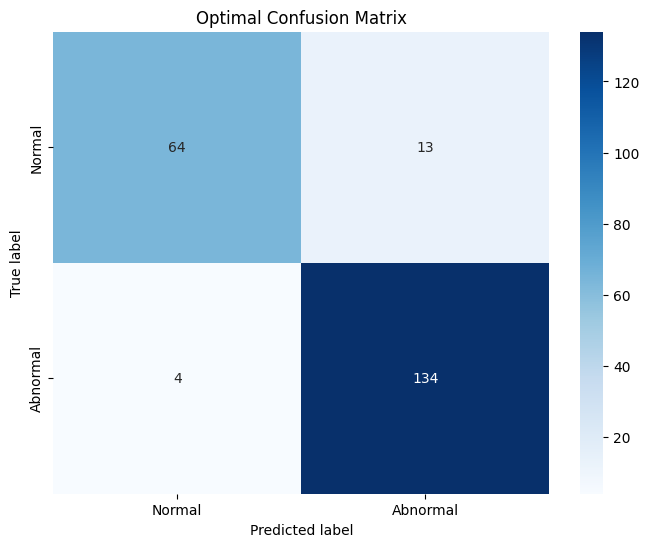

In [74]:
autoencoder = model_training(X_train_scaled, X_val_scaled)
model_evaluation(autoencoder,X_combined_test)

In [76]:
autoencoder.save('Encoder_Model.keras')

# 6. Feature Importance Analysis 

In [82]:
# Predict the reconstructed sounds for the combined test set
reconstructed_combined = autoencoder.predict(X_combined_test)

# Calculate the mean squared reconstruction error for each feature
mse_features = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=0)

# Rank features by reconstruction error
feature_importance_ranking = np.argsort(mse_features)[::-1]  # Features with the highest error first


# Print out the feature ranking with feature names
print("Feature importance ranking (from most to least important):")
for rank in feature_importance_ranking:
    print(f"{feature_names[rank]}: MSE = {mse_features[rank]}")


7/7 [==============================] - 0s 2ms/step
Feature importance ranking (from most to least important):
Autocorrelation: MSE = 275.91877718749674
Spectral Rolloff: MSE = 6.717705731120225
MFCC_8: MSE = 6.549364259038282
MFCC_5: MSE = 6.3203625667057795
MFCC_1: MSE = 5.293964766174264
MFCC_9: MSE = 4.1812250928887265
MFCC_6: MSE = 3.53513806404836
Spectral Centroid: MSE = 3.3615231176913327
MFCC_7: MSE = 2.620773568333878
MFCC_2: MSE = 2.5486822766559394
MFCC_13: MSE = 2.3483681118068556
MFCC_4: MSE = 2.0028651869477563
MFCC_12: MSE = 1.4372285528047406
Zero Crossing Rate: MSE = 1.3212800568813963
MFCC_10: MSE = 1.135146447439976
MFCC_3: MSE = 0.9911961571262909
Spectral Contrast: MSE = 0.9335566088546712
MFCC_11: MSE = 0.7921752737337318


The feature importance ranking shows that Feature 17 has a significantly higher mean squared error (MSE) than the others, which could indicate that it's very influential in the reconstruction process. This could mean that this feature varies considerably between normal and abnormal sounds, making it a strong candidate for further analysis or even for direct monitoring in a practical scenario.

# 7. Optimizing the model
## 7.1 Enhanced Feature Extraction

In [84]:
def extract_additional_features(audio, sample_rate):
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)
    spec_flatness = librosa.feature.spectral_flatness(y=audio)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)
    rms = librosa.feature.rms(y=audio)
    
    return np.mean(chroma_stft), np.mean(spec_bw), np.mean(spec_flatness), np.mean(rolloff), np.mean(rms)

def extract_features(audio_data, sample_rate):
    features = []
    for audio in audio_data:
        mfccs = extract_mfccs(audio, sample_rate)
        spectral_features = extract_spectral_features(audio, sample_rate)
        temporal_features = extract_temporal_features(audio)
        additional_features = extract_additional_features(audio, sample_rate)
        all_features = np.concatenate([mfccs, spectral_features, temporal_features, additional_features])
        features.append(all_features)
    return np.array(features)

# Extract features for both normal and abnormal data
normal_features = extract_features(normal_audio, sample_rate)
abnormal_features = extract_features(abnormal_audio, sample_rate)

In [90]:
normal_features.shape

(381, 23)

In [108]:
# Adding additional features to features list
additional_features = ['Chroma Features', 'Spectral Bandwidth', 'Spectral Flatness', 'Spectral Roll-off Frequency', 'Root Mean Square Energy']

# Combine all feature labels into a single list
feature_names = feature_names + additional_features
feature_names

['MFCC_1',
 'MFCC_2',
 'MFCC_3',
 'MFCC_4',
 'MFCC_5',
 'MFCC_6',
 'MFCC_7',
 'MFCC_8',
 'MFCC_9',
 'MFCC_10',
 'MFCC_11',
 'MFCC_12',
 'MFCC_13',
 'Spectral Centroid',
 'Spectral Rolloff',
 'Spectral Contrast',
 'Zero Crossing Rate',
 'Autocorrelation',
 'Chroma Features',
 'Spectral Bandwidth',
 'Spectral Flatness',
 'Spectral Roll-off Frequency',
 'Root Mean Square Energy',
 'Chroma Features',
 'Spectral Bandwidth',
 'Spectral Flatness',
 'Spectral Roll-off Frequency',
 'Root Mean Square Energy']

In [113]:
X_train, X_val = train_test_split(normal_features, test_size=0.2, random_state=42)
X_test = abnormal_features

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training, validation, and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Combine normal and abnormal data
X_combined_test = np.concatenate((X_val_scaled, X_test_scaled))
y_combined_test = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_test_scaled))))  # 0 for normal, 1 for abnormal

7/7 [==============================] - 0s 2ms/step
Optimal Threshold: 1.281891835449955
Accuracy: 0.9302325581395349
Precision: 0.948905109489051
Recall: 0.9420289855072463
F1 Score: 0.9454545454545454


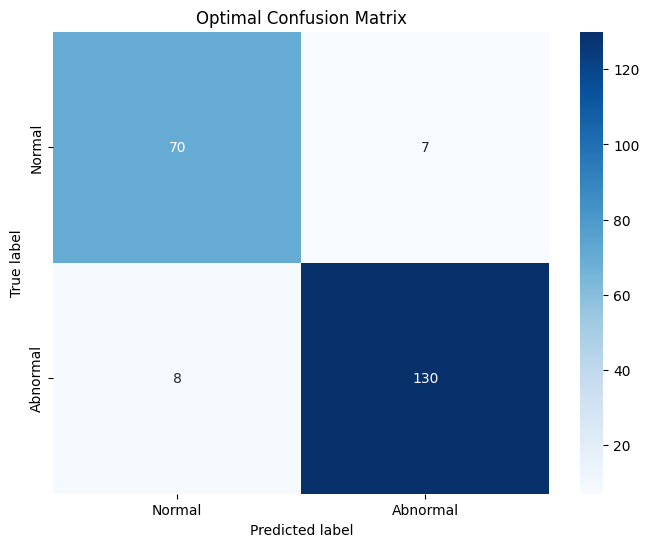

In [114]:
autoencoder = model_training(X_train_scaled, X_val_scaled)
model_evaluation(autoencoder,X_combined_test)

In [115]:
autoencoder.save('Encoder_Model2.keras')

In [116]:
# Predict the reconstructed sounds for the combined test set
reconstructed_combined = autoencoder.predict(X_combined_test)

# Calculate the mean squared reconstruction error for each feature
mse_features = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=0)

# Rank features by reconstruction error
feature_importance_ranking = np.argsort(mse_features)[::-1]  # Features with the highest error first

# Print out the feature ranking with feature names
print("Feature importance ranking (from most to least important):")
for rank in feature_importance_ranking:
    print(f"{feature_names[rank]}: MSE = {mse_features[rank]}")


7/7 [==============================] - 0s 2ms/step
Feature importance ranking (from most to least important):
Autocorrelation: MSE = 275.9200057522668
Root Mean Square Energy: MSE = 69.9303681148552
Spectral Bandwidth: MSE = 8.855609677095972
MFCC_5: MSE = 7.289478616634486
MFCC_8: MSE = 6.630602123282506
Spectral Roll-off Frequency: MSE = 5.311282054939604
Spectral Rolloff: MSE = 5.30942428439712
MFCC_1: MSE = 5.28295629300124
MFCC_9: MSE = 4.885762264910056
MFCC_6: MSE = 4.509769547499331
MFCC_7: MSE = 2.6612199224553796
Spectral Centroid: MSE = 2.2846397644537237
MFCC_2: MSE = 2.173415290008478
MFCC_4: MSE = 2.1270620043981134
MFCC_13: MSE = 1.9171352601239042
MFCC_10: MSE = 1.511825944932797
MFCC_12: MSE = 1.2751925716163874
Chroma Features: MSE = 1.0190227826801561
MFCC_3: MSE = 0.9967160162604478
Spectral Contrast: MSE = 0.8689860670821601
Spectral Flatness: MSE = 0.8468172649983584
MFCC_11: MSE = 0.795115748314642
Zero Crossing Rate: MSE = 0.7784579016050489


## 7.2 Feature Selection 

In [117]:
# Select the top N features
N = 10  # By trying different values
top_features_indices = feature_importance_ranking[:N]
top_features=[]
for rank in feature_importance_ranking[:N]:
    top_features.append(feature_names[rank])

top_features

['Autocorrelation',
 'Root Mean Square Energy',
 'Spectral Bandwidth',
 'MFCC_5',
 'MFCC_8',
 'Spectral Roll-off Frequency',
 'Spectral Rolloff',
 'MFCC_1',
 'MFCC_9',
 'MFCC_6']

In [120]:
# Subset the features for both normal and abnormal data
normal_features_subset = normal_features[:, top_features_indices]
abnormal_features_subset = abnormal_features[:, top_features_indices]

# Split and scale the data as before
X_train_subset, X_val_subset = train_test_split(normal_features_subset, test_size=0.2, random_state=42)
X_test_subset = abnormal_features_subset

scaler_subset = StandardScaler()
X_train_subset_scaled = scaler_subset.fit_transform(X_train_subset)
X_val_subset_scaled = scaler_subset.transform(X_val_subset)
X_test_subset_scaled = scaler_subset.transform(X_test_subset)

# Combine normal and abnormal data
X_combined_test = np.concatenate((X_val_subset_scaled, X_test_subset_scaled))
y_combined_test = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_test_scaled))))  # 0 for normal, 1 for abnormal


7/7 [==============================] - 0s 2ms/step
Optimal Threshold: 1.4279248339813693
Accuracy: 0.9488372093023256
Precision: 0.9703703703703703
Recall: 0.9492753623188406
F1 Score: 0.9597069597069596


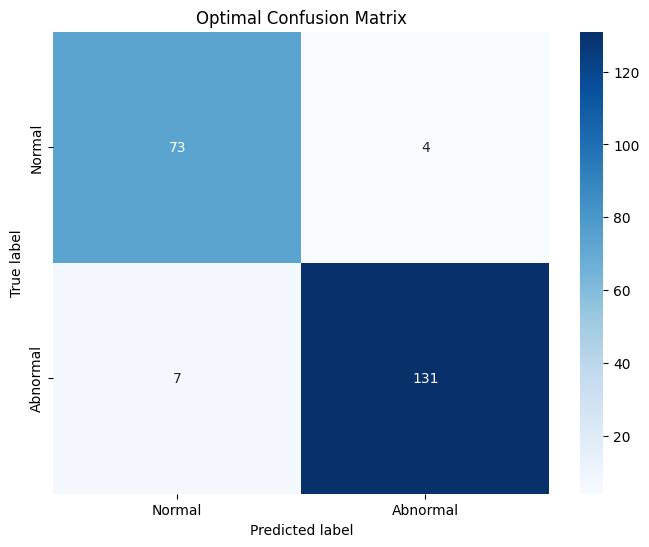

In [121]:
autoencoder2 = model_training(X_train_subset_scaled, X_val_subset_scaled)
model_evaluation(autoencoder2,X_combined_test)

In [122]:
# Predict the reconstructed sounds for the combined test set
reconstructed_combined = autoencoder2.predict(X_combined_test)

# Calculate the mean squared reconstruction error for each feature
mse_features = np.mean(np.power(X_combined_test - reconstructed_combined, 2), axis=0)

# Rank features by reconstruction error
feature_importance_ranking = np.argsort(mse_features)[::-1]  # Features with the highest error first


# Print out the feature ranking with feature names
print("Feature importance ranking (from most to least important):")
for rank in feature_importance_ranking:
    print(f"{top_features[rank]}: MSE = {mse_features[rank]}")


7/7 [==============================] - 0s 2ms/step
Feature importance ranking (from most to least important):
Autocorrelation: MSE = 275.89850143302294
Root Mean Square Energy: MSE = 69.89562105481436
Spectral Bandwidth: MSE = 8.826741214607512
MFCC_8: MSE = 8.623159619038821
MFCC_5: MSE = 7.42613141899667
Spectral Rolloff: MSE = 7.145803693382713
Spectral Roll-off Frequency: MSE = 6.829338792156673
MFCC_1: MSE = 5.345245419825377
MFCC_9: MSE = 4.11792726441158
MFCC_6: MSE = 3.562618055781357


In [124]:
autoencoder2.save('Encoder_Model3.keras')

# 7.Conclusion
As the curtain falls on this phase of the Pump-Net project, a reflection on the journey reveals a narrative of growth and deepened understanding. This project carved out a new path in anomaly detection by embracing the complexities of unsupervised learning, moving beyond the scope of the initial supervised model that had set a high standard in precision and reliability.

The transition to unsupervised learning techniques was not merely a choice but a necessity, driven by the real-world rarity of anomalies and the vast array of unpredictable sounds that industrial machinery can produce. This approach has empowered the model to identify deviations from the norm without the crutch of pre-labeled anomalous data. The resulting system has shown a commendable ability to generalize from known operational sounds to detect outliers, thereby enhancing its utility for predictive maintenance.

Comparatively, while the supervised learning model excelled with higher accuracy and precision, its reliance on labeled anomaly data presented limitations in scalability and adaptability. In contrast, the unsupervised model, although slightly less accurate, offers a robust framework that stands ready to tackle the unpredictability of real-world machine operations. It holds its own with respectable performance metrics, achieving an F1 score that speaks to its efficacy.

In essence, the unsupervised Pump-Net model has not only met the challenge but also opened the door to future advancements. The insights gained and the data patterns recognized pave the way for continuous improvement and application in diverse industrial scenarios. This project serves as a testament to the evolving landscape of industrial anomaly detection, where each step forward is a leap towards operational excellence and machinery safety.